## 1. FOPDT Simulation for Generating training Data

In [1]:
try:
    from gekko import GEKKO
except:
    !pip install gekko
    # restart kernel if this doesn't import
    from gekko import GEKKO

In [2]:
# from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# from smt.sampling_methods import LHS
# from smt.sampling_methods import Random

In [3]:
#%% Mount Google drive if you use colab for save and load LSTM models
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')
    
else:
  print('Not running on Colab')

Running on Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
tf = 30 # fianl time

In [5]:
m=GEKKO(remote=False)
m.time = np.linspace(0,tf-1,tf)

In [6]:
K = m.FV(1) # Process Gain
tau = m.FV(2) # Time Constant

In [7]:
u_input = np.zeros(tf)
u_input[5:] = 1

In [8]:
y = m.CV()
u = m.MV(u_input)
m.Equation(tau*y.dt()+y==K*u) #FOPDT Equation

m.options.IMODE=4

In [9]:
m.solve(disp=False)

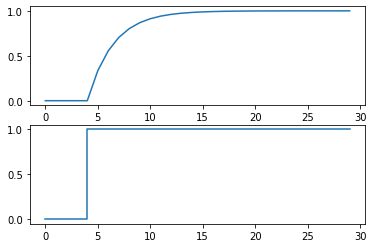

In [10]:
plt.figure(0)
plt.subplot(2,1,1)
plt.plot(m.time, y)
plt.subplot(2,1,2)
plt.plot(m.time, u, drawstyle='steps')
plt.show()

## 2. Generating input signal (Random and LHS)

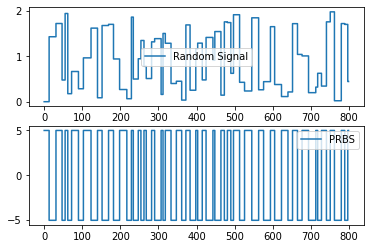

In [11]:
import numpy as np
import matplotlib.pyplot as plt

nstep = 800 # Choose training data lenth

# random signal generation

a_range = [0,2]
a = np.random.rand(nstep) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude
a[0] = 0

b_range = [5, 20]
b = np.random.rand(nstep) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
b = np.round(b)
b = b.astype(int)

b[0] = 0

for i in range(1,np.size(b)):
    b[i] = b[i-1]+b[i]

# Random Signal
i=0
random_signal = np.zeros(nstep)
while b[i]<np.size(random_signal):
    k = b[i]
    random_signal[k:] = a[i]
    i=i+1

# PRBS
a = np.zeros(nstep)
j = 0
while j < nstep:
    a[j] = 5
    a[j+1] = -5
    j = j+2

i=0
prbs = np.zeros(nstep)
while b[i]<np.size(prbs):
    k = b[i]
    prbs[k:] = a[i]
    i=i+1

plt.figure(0) 
plt.subplot(2,1,1)
plt.plot(random_signal, drawstyle='steps',label='Random Signal')
plt.legend()
plt.subplot(2,1,2)
plt.plot(prbs, drawstyle='steps', label='PRBS')
plt.legend()
plt.show()

## 3. Evaluate the Random Input Signal

In [12]:
tf = nstep
m.time = np.linspace(0,tf-1,tf)
u.value = random_signal

In [13]:
m.options.IMODE = 4
m.solve(disp=False)

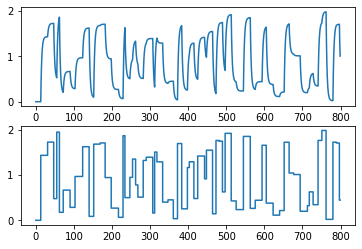

In [14]:
plt.figure(0)
plt.subplot(2,1,1)
plt.plot(m.time, y)
plt.subplot(2,1,2)
plt.plot(m.time, u, drawstyle='steps')
plt.show()

## 4. Train LSTM Network

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import time

In [16]:
# For LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model

In [17]:
window = 5
#Load training data
data = pd.DataFrame(
        {"u": u,
         "y": y},
        index = np.linspace(1,nstep,nstep,dtype=int))

In [18]:
# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(data[['u','y']])
s2 = MinMaxScaler(feature_range=(-1,1))
Ys = s2.fit_transform(data[['y']])

In [19]:
Ys.shape

(800, 1)

In [20]:
Xs.shape

(800, 2)

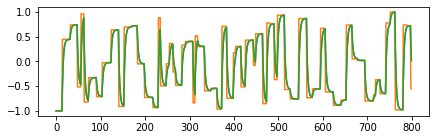

In [21]:
plt.figure(figsize=[7,2])
plt.plot(Ys)
plt.plot(Xs)

In [22]:
#%% Save MinMaxScaler file
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  joblib.dump(s1, '/content/drive/MyDrive/LSTM_MPC/FOPDT/s1.sav')
  joblib.dump(s2, '/content/drive/MyDrive/LSTM_MPC/FOPDT/s2.sav')
    
else:
  print('Not running on Colab')
  joblib.dump(s1, 's1.sav')
  joblib.dump(s2, 's2.sav')

Running on Colab


In [23]:
val_ratio = 0.5
cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set
print(cut_index)
Xs_train = Xs[0:cut_index]
Ys_train = Ys[0:cut_index]
Xs_val = Xs[cut_index:]
Ys_val = Ys[cut_index:]

400


In [24]:
X_train = []
Y_train = []
for i in range(window,len(Xs_train)):
    X_train.append(Xs_train[i-window:i,:])
    Y_train.append(Ys_train[i])

X_val = []
Y_val = []
for i in range(window,len(Xs_val)):
    X_val.append(Xs_val[i-window:i,:])
    Y_val.append(Ys_val[i])


In [25]:
# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [26]:
np.shape(X_train), np.shape(Y_train)

((395, 5, 2), (395, 1))

In [27]:
Y_train.shape[1]

1

In [28]:
# # Initialize LSTM model
model = Sequential()

model.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=Y_train.shape[1])) #units = number of outputs
model.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])
# Allow for early exit
es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

In [29]:
# Fit (and time) LSTM model
t0 = time.time()
history = model.fit(X_train, Y_train, epochs = 300, batch_size = 250, callbacks=[es], verbose=1, validation_data=(X_val, Y_val))
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

Epoch 1/300
2/2 [==============================] - 7s 1s/step - loss: 0.2841 - accuracy: 0.0000e+00 - val_loss: 0.3289 - val_accuracy: 0.0000e+00
Epoch 2/300
2/2 [==============================] - 0s 43ms/step - loss: 0.2562 - accuracy: 0.0000e+00 - val_loss: 0.2784 - val_accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 0s 41ms/step - loss: 0.2092 - accuracy: 0.0000e+00 - val_loss: 0.2188 - val_accuracy: 0.0000e+00
Epoch 4/300
2/2 [==============================] - 0s 42ms/step - loss: 0.1670 - accuracy: 0.0000e+00 - val_loss: 0.1571 - val_accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 0s 42ms/step - loss: 0.1244 - accuracy: 0.0000e+00 - val_loss: 0.1182 - val_accuracy: 0.0025
Epoch 6/300
2/2 [==============================] - 0s 43ms/step - loss: 0.1042 - accuracy: 0.0000e+00 - val_loss: 0.1154 - val_accuracy: 0.0025
Epoch 7/300
2/2 [==============================] - 0s 44ms/step - loss: 0.1082 - accuracy: 0.0000e+00 - val_loss: 0.0977 -

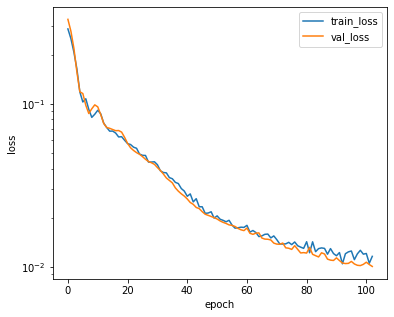

In [30]:
# Plot loss
plt.figure(figsize=(6,5))
plt.semilogy(history.history['loss'],label='train_loss')
plt.semilogy(history.history['val_loss'],label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss')
# plt.savefig('FOPDT_loss.png')
plt.legend()

In [34]:
#%% Save model file
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  model.save('/content/drive/MyDrive/LSTM_MPC/FOPDT/model.h5')
    
else:
  print('Not running on Colab')
  model.save('model.h5')

Running on Colab


## 5. Using measured values to predict next step

In [35]:
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  model = load_model('/content/drive/MyDrive/LSTM_MPC/FOPDT/model.h5')
  
else:
  print('Not running on Colab')
  model = load_model('model.h5')

Running on Colab


In [37]:
Yp_train = model.predict(X_train)

In [38]:
np.shape(Yp_train)

(395, 1)

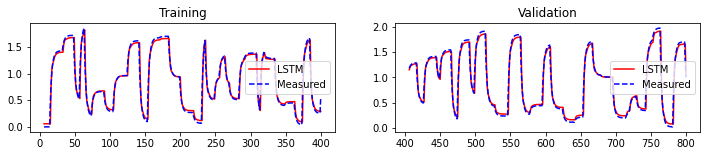

In [39]:
# Verify the fit of the model
Yp_train = model.predict(X_train)
Yp_val = model.predict(X_val)

# un-scale outputs
Yu_train = s2.inverse_transform(Yp_train)
Ym_train = s2.inverse_transform(Y_train)

Yu_val = s2.inverse_transform(Yp_val)
Ym_val = s2.inverse_transform(Y_val)

plt.figure(0, figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index],Yu_train[:,0],'r-',label='LSTM')
plt.plot(data.index[window:cut_index],Ym_train[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:],Yu_val[:,0],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:],Ym_val[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()

## 6. Using predicted values to predict next step

In [40]:
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  model = load_model('/content/drive/MyDrive/LSTM_MPC/FOPDT/model.h5')
  
else:
  print('Not running on Colab')
  model = load_model('model.h5')

Running on Colab


In [41]:
Xsq = Xs.copy()   # Xs : scaled data before appending array
Yv = []
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model.predict(Xin) # (Xs.shape[1]-Ys.shape[1]) indicates the index of the first output variable in the LSTM input array
    Yv.append(Xsq[i][(Xs.shape[1] - Ys.shape[1]):])

Ytu = s2.inverse_transform(Yv)
# Break Ytu into train and validation set for plotting
Ytu_train = Ytu[0:cut_index-window]
Ytu_val = Ytu[cut_index:]

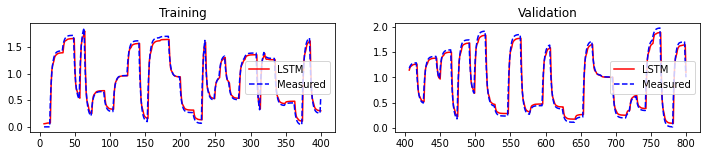

In [42]:
plt.figure(0, figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index],Ytu_train[:,0],'r-',label='LSTM')
plt.plot(data.index[window:cut_index],Ym_train[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:],Ytu_val[:,0],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:],Ym_val[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()